# 🧙 Predicting TikTok Hits with Bayesian Magic 🧙

Inflooence Sprint 4

We're not necessarily using Bayes' theorem here, but I think there's some level of implied prior construction happening, so I think it's fair to call it Bayesian.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import math

## Load the Dataset
We load the dataset of viral TikTok songs downloaded from our SQL database, which was scraped from the TikTok/Spotify APIs

In [2]:
column_names = [
    'Title', 'Artist', 'ID', 'Acousticness', 'Danceability', 'Energy', 'Liveness', 'Loudness', 'Tempo', 'time_signature', 'url'
]

df = pd.read_csv('db.csv', header=None)
df.columns = column_names
df.head()

,Title,Artist,ID,Acousticness,Danceability,Energy,Liveness,Loudness,Tempo,time_signature,url
0,Monkeys Spinning Monkeys,Kevin MacLeod & Kevin The Monkey,0,0.000,0.000,0.000,0.0000,0.000,0.000,0,no_url
1,Love You So,The King Khan & BBQ Show,5rwQGBi5mdmU7dqNM7x9Oo,0.714,0.398,0.909,0.2860,-2.493,115.162,4,https://i.scdn.co/image/ab67616d00001e02894ecd...
2,Made You Look,Meghan Trainor,0QHEIqNKsMoOY5urbzN48u,0.345,0.838,0.525,0.0771,-3.562,144.981,4,https://i.scdn.co/image/ab67616d00001e021a4f1a...
3,Halloween ・ cute horror song,PeriTune,0,0.000,0.000,0.000,0.0000,0.000,0.000,0,no_url
4,original sound - o.zuxedits,ꨄꨄ,0,0.000,0.000,0.000,0.0000,0.000,0.000,0,no_url


## Extract Predictive Features
From the dataset, we can see that Acousticness, Danceability, Energy, Liveness, Loudness, and Tempo might be useful predictive features

In [3]:
fdf = features_df = df[['Acousticness', 'Danceability', 'Energy', 'Liveness', 'Loudness', 'Tempo']]
features_df.head()

,Acousticness,Danceability,Energy,Liveness,Loudness,Tempo
0,0.000,0.000,0.000,0.0000,0.000,0.000
1,0.714,0.398,0.909,0.2860,-2.493,115.162
2,0.345,0.838,0.525,0.0771,-3.562,144.981
3,0.000,0.000,0.000,0.0000,0.000,0.000
4,0.000,0.000,0.000,0.0000,0.000,0.000


## Correlation Matrix
We generate a matrix of Pearson correlation coefficients to see if there might be any interesting correlations between features of our data

In [4]:
features_df.corr()

,Acousticness,Danceability,Energy,Liveness,Loudness,Tempo
Acousticness,1.000000,0.515098,0.415238,0.562000,-0.634072,0.717691
Danceability,0.515098,1.000000,0.893100,0.741420,-0.902684,0.945692
Energy,0.415238,0.893100,1.000000,0.860669,-0.715232,0.838972
Liveness,0.562000,0.741420,0.860669,1.000000,-0.691464,0.783959
Loudness,-0.634072,-0.902684,-0.715232,-0.691464,1.000000,-0.920295
Tempo,0.717691,0.945692,0.838972,0.783959,-0.920295,1.000000


## Normalization
We normalize the data by transforming all our features to have mean 0 and variance 1, which makes it a lot easier to use with machine learning models

In [5]:
normalized_features = (fdf - fdf.mean()) / fdf.std()
lookup = np.asarray(normalized_features)
normalized_features.head()

,Acousticness,Danceability,Energy,Liveness,Loudness,Tempo
0,-0.485107,-0.781811,-0.746240,-0.669591,0.720957,-0.782204
1,2.184590,0.293877,2.020958,3.243694,0.072728,1.033860
2,0.804873,1.483080,0.851976,0.385354,-0.205234,1.504095
3,-0.485107,-0.781811,-0.746240,-0.669591,0.720957,-0.782204
4,-0.485107,-0.781811,-0.746240,-0.669591,0.720957,-0.782204


# Euclid and Gauss 🤓🧠
We center 30 "tall" Gaussian distributions (tall meaning we scale them vertically into probability mass functions whose height at the mean is 1.0) on the datapoints corresponding to each of our 30 TikTok hit songs. To predict the probability of a new song being a hit, we take its Euclidean distance from each of the 30 points and plug those distances as plus-or-minus x into their corresponding Gaussian mass functions. We simply take the max() of these 30 probability mass function outputs to get our predicted hit probability. Essentially, this method guesses the probability that a song goes viral by checking how close it is to known hit songs in our dataset.

In [6]:
def euclid_gauss(sigma):
    return lambda d: math.e ** (-0.5 * d**2 / sigma**2)

def tall_gauss(mu, sigma):
    return lambda x: euclid_gauss(sigma)(x - mu)

def gauss_attention(means, sigma=None):
    if sigma == None:
        sigma = 1 / math.sqrt(len(means))
    def f(x):
        try:
            return[f(x_i) for x_i in x]
        except:
            return max([tall_gauss(mu, sigma)(x) for mu in means])
    return f

Here's a visualization of the single-feature predictor functions for each of our 6 features. These can be sort of be seen as averaged "cross sections" of our overall model, which would be a 6-dimensional mass function whose dimensions represent acousticness, danceability, energy, liveness, loudness, and tempo.

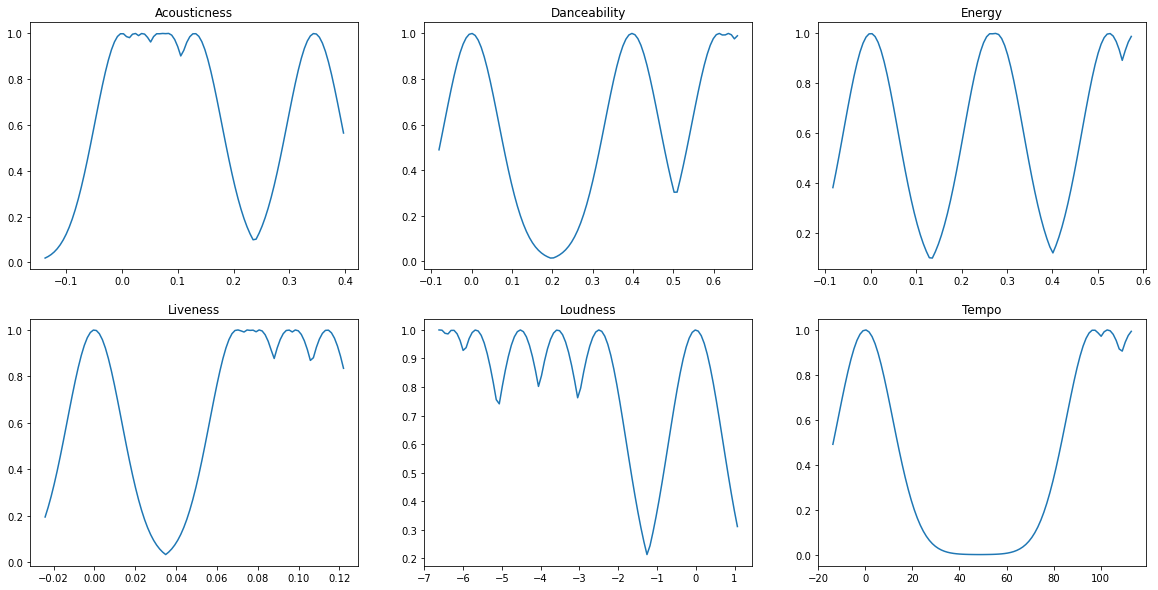

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

for i in range(lookup.shape[1]):
    means = lookup[:,i]
    attention_fn = gauss_attention(means)
    X = np.linspace(-1, 1, 100)
    mean = fdf.mean()[i]
    std = fdf.std()[i]
    plotX = X * std + mean
    axes[i//3, i%3].set_title(features_df.columns[i])
    axes[i//3, i%3].plot(plotX, attention_fn(X))